In [1]:
from main import DCNN1D
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
DIR = 'save_cnn1d_7/'
model2 = DCNN1D(istest=True,path_model=DIR)

[0226 16:47:31] Loading configuration and datasets start...
[0226 16:47:32] Loading configuration and datasets done.
[0226 16:47:32] Building model start...


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



[0226 16:47:32] From /home/titan/software/cnn1d/main.py:133: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

[0226 16:47:32] Building model done.


In [3]:
model2.restore()

Load the model from ./save_cnn1d_7/model.ckpt-500
INFO:tensorflow:Restoring parameters from ./save_cnn1d_7/model.ckpt-500


[0226 16:47:33] Restoring parameters from ./save_cnn1d_7/model.ckpt-500


In [5]:
tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

[<tf.Variable 'conv1d/kernel:0' shape=(20, 1, 18) dtype=float32_ref>,
 <tf.Variable 'conv1d/bias:0' shape=(18,) dtype=float32_ref>,
 <tf.Variable 'conv1d_1/kernel:0' shape=(20, 18, 36) dtype=float32_ref>,
 <tf.Variable 'conv1d_1/bias:0' shape=(36,) dtype=float32_ref>,
 <tf.Variable 'conv1d_2/kernel:0' shape=(20, 36, 72) dtype=float32_ref>,
 <tf.Variable 'conv1d_2/bias:0' shape=(72,) dtype=float32_ref>,
 <tf.Variable 'conv1d_3/kernel:0' shape=(20, 72, 144) dtype=float32_ref>,
 <tf.Variable 'conv1d_3/bias:0' shape=(144,) dtype=float32_ref>,
 <tf.Variable 'dense/kernel:0' shape=(147456, 7) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(7,) dtype=float32_ref>]

In [18]:
kernels = []
for i in range(len(model2.filters)):
    if i == 0:
        layer = ''
    else:
        layer = '_'+str(i)
    conv1d_var = [v for v in tf.global_variables() if v.name == "conv1d"+layer+"/kernel:0"][0]
    kernels.append(model2.sess.run(conv1d_var))
len(kernels)

4

In [92]:
N = model2.seq_length
T = 1.0 / 50000.
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
freq_kernels = []
for n,kernel in enumerate(kernels):
    freq_kernel = np.zeros((N//2,kernel.shape[1],kernel.shape[2]))
    for second in range(kernel.shape[1]):
        for third in range(kernel.shape[2]):
            kern = np.zeros((N,))
            kern[:kernel.shape[0]*(n+1)] = np.repeat(kernel[:,second,third], n+1)
            yf = np.abs(scipy.fftpack.fft(kern)) * 2 / N
            freq_kernel[:,second,third] = yf[:N//2]
    freq_kernels.append(freq_kernel.copy())

(8192, 72)

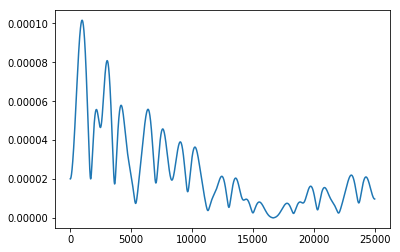

In [93]:
plt.plot(xf,freq_kernels[2][:,0,0])
freq_kernel[:,:,0].shape

In [94]:
spectrum_layer = []
last_spectrum = np.ones((N//2,model2.n_channels))
for freq_kernel in freq_kernels:
    filters = np.zeros((last_spectrum.shape[0], last_spectrum.shape[1], freq_kernel.shape[2]))
    for i_filters in range(freq_kernel.shape[2]):
        filters[:,:,i_filters] = last_spectrum * freq_kernel[:,:,i_filters]
    last_spectrum = filters.sum(axis=1)
    spectrum_layer.append(last_spectrum.copy())

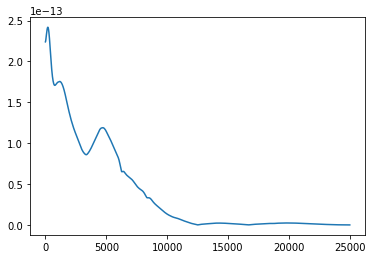

In [95]:
plt.plot(xf,spectrum_layer[3].mean(axis=1))

test_loss = 0.000000, acc = 1.000
[[0. 0. 0. 1. 0. 0. 0.]]


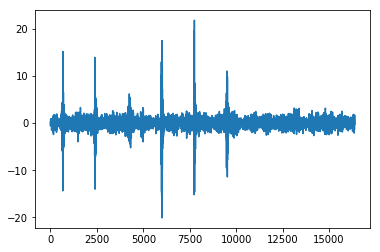

In [101]:
x, y = model2.next_batch(stage='Test')
feed_dict = {model2.inputs_: x, model2.labels_: y}
test_loss, acc = model2.sess.run([model2.cost, model2.accuracy], feed_dict=feed_dict)
print("test_loss = {:.6f}, acc = {:.3f}".format(test_loss, acc))
print(y)
plt.plot(x.squeeze());

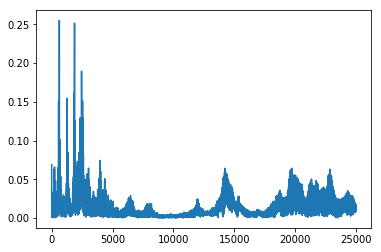

In [102]:
yf = np.abs(scipy.fftpack.fft(x.squeeze())) * 2 / N
plt.plot(xf,yf[:N//2])

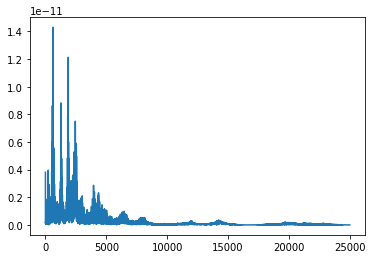

In [104]:
plt.plot(xf,yf[:N//2] * spectrum_layer[2].mean(axis=1))

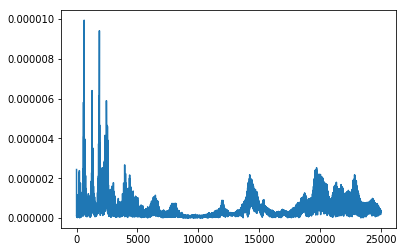

In [108]:
plt.plot(xf,yf[:N//2] * spectrum_layer[0].mean(axis=1))